# Segmentation of Indian Traffic

In [ ]:
!pip install tensorflow==2.2.0
!pip install keras==2.3.1
!pip install segmentation-models

In [ ]:
import tensorflow
tensorflow.__version__

'2.2.0'

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import imgaug.augmenters as iaa

import pandas as pd
import os
from os import path
from tqdm.notebook import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import urllib.request
import pathlib
from pathlib import Path

import tensorflow as tf

from tqdm.notebook import tqdm

# https://drive.google.com/drive/folders/1bynkOIXCurhJ9_Y5Q14KWX5yDyCRkKfN

In [ ]:
if 'data.zip' not in os.listdir(): 
    !wget https://www.dropbox.com/s/cok7zvnqukm8fok/data.zip
    get_ipython().system_raw("7z x data.zip")

<pre>
1. Download the data from this link, and extract it

2. All the data will be in the folder "data" 


|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    root = pathlib.Path(root_dir)
    img_paths = list(root.rglob("*.jpg*"))
    img_paths_lst = [str(path) for path in img_paths]
    
    frame_name_lst = []
    for p in img_paths_lst:
        frame_name =  '/'.join(p.split("_")[0].split('/')[-2:])
        frame_name_lst.append(frame_name)
    img_frame_df = pd.DataFrame(list(zip(img_paths_lst, frame_name_lst)), columns =['image', 'frame_name'])

    root = pathlib.Path('data')
    json_paths = list(root.rglob("*.json*"))
    json_paths_lst = [str(path) for path in json_paths]

    frame_name_lst = []
    for p in json_paths_lst:
        frame_name = '/'.join(p.split("_")[0].split('/')[-2:])
        frame_name_lst.append(frame_name)
    json_frame_df = pd.DataFrame(list(zip(json_paths_lst, frame_name_lst)), columns =['json', 'frame_name'])

    data_df = pd.merge(img_frame_df, json_frame_df, on='frame_name')
    data_df = data_df.drop('frame_name', axis=1)
    return data_df

In [ ]:
data_df = return_file_names_df(root_dir='data')
data_df.head()

,image,json
0,data/images/213/frame10112_leftImg8bit.jpg,data/mask/213/frame10112_gtFine_polygons.json
1,data/images/213/frame36271_leftImg8bit.jpg,data/mask/213/frame36271_gtFine_polygons.json
2,data/images/213/frame33180_leftImg8bit.jpg,data/mask/213/frame33180_gtFine_polygons.json
3,data/images/213/frame66249_leftImg8bit.jpg,data/mask/213/frame66249_gtFine_polygons.json
4,data/images/213/frame48453_leftImg8bit.jpg,data/mask/213/frame48453_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels=set()
    for json_file in tqdm(data_df['json'].values):
        with open(json_file) as f:
            json_data = json.load(f)
            for jd_obj in json_data['objects']:
                unique_labels.add(jd_obj['label'])

    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
len(unique_labels)

40

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    label = []
    vertexlist = []
    
    with open(file) as f:
        json_data = json.load(f)
        w = json_data['imgWidth']
        h = json_data['imgHeight']
        for jd_obj in json_data['objects']:
            label.append(jd_obj['label'])
            vertex_i = []
            for vi in jd_obj['polygon']:
                vertex_i.append(tuple(vi))
            vertexlist.append(vertex_i)

    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

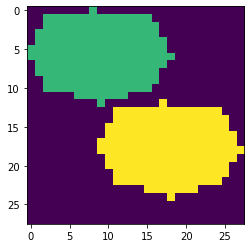

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    mask_path_lst = []
    for img_file, json_file in tqdm(data_df.values):
        # get w, h, labels and vertex list from this json file
        w, h, labels, vertexlist = get_poly(json_file)
        #print("Working on json file=",json_file)
        img = Image.new("L", (w, h))    # 'L' creates a gray scale image. 
                                        # Refer different modes, https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
        img1 = ImageDraw.Draw(img)
        
        for i in range(len(vertexlist)):
            try:
                img1.polygon(vertexlist[i], fill=label_clr[labels[i]])
            except:
                #print("json file=",json_file,";label",labels[i],";vertex is=",vertexlist[i])
                pass

        path_tokens = json_file.split("/")
        data_root = path_tokens[0]
        output = 'output'
        scene = path_tokens[2]

        Path('/'.join([data_root,output,scene])).mkdir(parents=True, exist_ok=True)
        frame_number = path_tokens[3].split(".")[0]

        mask_path = '/'.join([data_root,output,scene,frame_number])
        mask_path += ".png"
        img.save(mask_path, format="png")
        mask_path_lst.append(mask_path)

    data_df['mask'] = mask_path_lst
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

,image,json,mask
0,data/images/213/frame10112_leftImg8bit.jpg,data/mask/213/frame10112_gtFine_polygons.json,data/output/213/frame10112_gtFine_polygons.png
1,data/images/213/frame36271_leftImg8bit.jpg,data/mask/213/frame36271_gtFine_polygons.json,data/output/213/frame36271_gtFine_polygons.png
2,data/images/213/frame33180_leftImg8bit.jpg,data/mask/213/frame33180_gtFine_polygons.json,data/output/213/frame33180_gtFine_polygons.png
3,data/images/213/frame66249_leftImg8bit.jpg,data/mask/213/frame66249_gtFine_polygons.json,data/output/213/frame66249_gtFine_polygons.png
4,data/images/213/frame48453_leftImg8bit.jpg,data/mask/213/frame48453_gtFine_polygons.json,data/output/213/frame48453_gtFine_polygons.png


In [ ]:
data_df = pd.read_csv("preprocessed_data.csv")

In [ ]:
data_df.head()

,image,json,mask
0,data/images/213/frame10112_leftImg8bit.jpg,data/mask/213/frame10112_gtFine_polygons.json,data/output/213/frame10112_gtFine_polygons.png
1,data/images/213/frame36271_leftImg8bit.jpg,data/mask/213/frame36271_gtFine_polygons.json,data/output/213/frame36271_gtFine_polygons.png
2,data/images/213/frame33180_leftImg8bit.jpg,data/mask/213/frame33180_gtFine_polygons.json,data/output/213/frame33180_gtFine_polygons.png
3,data/images/213/frame66249_leftImg8bit.jpg,data/mask/213/frame66249_gtFine_polygons.json,data/output/213/frame66249_gtFine_polygons.png
4,data/images/213/frame48453_leftImg8bit.jpg,data/mask/213/frame48453_gtFine_polygons.json,data/output/213/frame48453_gtFine_polygons.png


In [ ]:
from sklearn.model_selection import train_test_split
X_train_df, X_test_df = train_test_split(data_df, test_size=0.10, random_state=42)

In [ ]:
print(X_train_df.shape)
print(X_test_df.shape)

(3607, 3)
(401, 3)


In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(image[:,:,0].shape)
        plt.imshow(image[:,:,0])
    plt.show()

(512, 512)


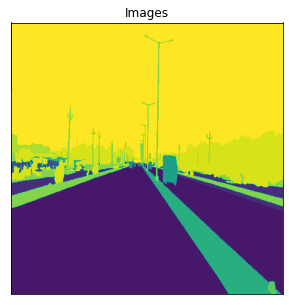

In [ ]:
abc = cv2.imread(X_train_df['mask'].values[0])
visualize(images=abc)

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
# import imgaug.augmenters as iaa
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
X_train_df['mask'].values[0]

'data/output/266/frame5798_gtFine_polygons.png'

In [ ]:
class Dataset:
    def __init__(self, paths_df, label_clr, is_training=False):
        #self.ids = file_names
        # the paths of images
        self.images_fps = paths_df['image'].values
        # the paths of segmentation images
        self.masks_fps = paths_df['mask'].values
        # giving labels for each class
        #self.class_values = list(map(lambda x: x//10, set(label_clr.values()))) # This will get us all 21 classes from the 'label_clr', ranging from 0 to 20
        self.class_values = set(label_clr.values())
        self.is_training = is_training

    def normalize_image(self, mask):
        mask = mask/255
        return mask
    
    def __getitem__(self, i):
        # read data
        full_size_image = cv2.imread(self.images_fps[i])
        #full_size_image = full_size_image[:,:,0]
        image = cv2.resize(full_size_image, (512,512), interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        full_size_mask  = cv2.imread(self.masks_fps[i])
        #full_size_mask = full_size_mask[:,:,0]
        image_mask = cv2.resize(full_size_mask, (512,512), interpolation=cv2.INTER_NEAREST)
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)
        #image_mask = self.normalize_image(image_mask)
        
        image_masks = [(image_mask[:,:,0] == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.is_training:
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
BATCH_SIZE=8
# Dataset for train images
train_dataset = Dataset(X_train_df, label_clr, is_training=True)
test_dataset  = Dataset(X_test_df, label_clr, is_training=False)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 21)

(8, 512, 512, 3)


In [ ]:
len(train_dataloader)

450

# Task 3: Training CANet

* Implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* You can divide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder

    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128,128,8$
        * the output after $C_2$ will be $64,64,16$
        * the output after $C_3$ will be $64,64,32$
        * the output after $C_4$ will be $64,64,64$

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D, SpatialDropout2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, ReLU, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
#tf.config.run_functions_eagerly(True)
tf.config.experimental_run_functions_eagerly(True)

import segmentation_models as sm

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

To learn more on Residual Skip connection. Read from 'Skip connections for the win' heading<br>
<a href='https://theaisummer.com/skip-connections/'>link</a>

How to use custom layers effectively<br>
<a href='https://stackoverflow.com/a/58863754/7697658'>https://stackoverflow.com/a/58863754/7697658</a>

In [ ]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1):
        super().__init__()
        self.F1, self.F2, self.F3 = filters #c1=[4,4,8], c2=[8,8,16], c3=[16,16,32], c4=[32,32,64]
        self.kernel = kernel
        self.stride = stride    # c1=2, c2=2, c3=1, c4=1
        self.conv_1_1_1 = Conv2D(filters=self.F1, kernel_size=(1,1), strides=1, padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.conv_3_3_1 = Conv2D(filters=self.F2, kernel_size=(3,3), strides=self.stride, padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_1_1_2 = Conv2D(filters=self.F3, kernel_size=(1,1), strides=1, padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_3_3_parellel = Conv2D(filters=self.F3, kernel_size=(3,3), strides=self.stride, padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.bn_parellel = BatchNormalization()
        
    # kernel_regularizer=regularizers.l2(0.01)
    def call(self, X):
        # write the architecutre that was mentioned above
        cb_1 = self.conv_1_1_1(X)
        cb_1 = self.bn_1(cb_1)
        cb_1 = Activation('relu')(cb_1)
        #print('---cb_1=',cb_1.shape)

        cb_2 = self.conv_3_3_1(cb_1)
        cb_2 = self.bn_2(cb_2)
        cb_2 = Activation('relu')(cb_2)
        #print('---cb_2=',cb_2.shape)

        cb_3 = self.conv_1_1_2(cb_2)
        cb_3 = self.bn_3(cb_3)
        #print('---cb_3=',cb_3.shape)
        #---

        #--conv parellel block---#
        cb_parellel = self.conv_3_3_parellel(X)
        cb_parellel = self.bn_parellel(cb_parellel)
        cb_parellel = Activation('relu')(cb_parellel)
        #print('---cb_parellel=',cb_parellel.shape)
        #--conv parellel block---#

        out = Add()([cb_3, cb_parellel])
        X = Activation('relu')(out)

        return X

In [ ]:
class Identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3, filters=[4,4,8]):
        super().__init__()
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv_1_1_1 = Conv2D(filters=self.F1, kernel_size=(1,1), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.bn_1 = BatchNormalization()
        self.conv_3_3_1 = Conv2D(filters=self.F2, kernel_size=(3,3), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.bn_2 = BatchNormalization()
        self.conv_1_1_2 = Conv2D(filters=self.F3, kernel_size=(1,1), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.bn_3 = BatchNormalization()
        
    def call(self, X):
        # write the architecutre that was mentioned above
        ib_1 = self.conv_1_1_1(X)
        ib_1 = self.bn_1(ib_1)
        ib_1 = Activation('relu')(ib_1)
        #print('---ib_1=',ib_1.shape)
        
        ib_2 = self.conv_3_3_1(ib_1)
        ib_2 = self.bn_2(ib_2)
        ib_2 = Activation('relu')(ib_2)
        #print('---ib_2=',ib_2.shape)
        
        ib_3 = self.conv_1_1_2(ib_2)
        ib_3 = self.bn_3(ib_3)
        #print('---ib_3=',ib_3.shape)
        #---
        #print('---ib_parellel=',X.shape)

        out = Add()([ib_3, X])
        X = Activation('relu')(out)

        return X

In [ ]:
tf.keras.backend.clear_session()
def self_grader_conv_iden_blocks():
    output = tf.random.uniform(shape=[1,512,512,3])
    c_filters_lst = [[], [4,4,8], [8,8,16], [16,16,32], [32,32,64]]
    c_strides_lst = [0,4,2,1,1]
    for k in range(1,5):
        output = Convolutional_block(filters=c_filters_lst[k], stride=c_strides_lst[k])(output)
        #print("=>Conv block",k,"=",output.shape)
        for j in range(k):
            output = Identity_block(filters=[output.shape[3]]*3)(output)
            #print("=>Identity block",k,"->",j,"=",output.shape)
        print("C"+str(k),"->",output.shape)
self_grader_conv_iden_blocks()

C1 -> (1, 128, 128, 8)
C2 -> (1, 64, 64, 16)
C3 -> (1, 64, 64, 32)
C4 -> (1, 64, 64, 64)


* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but here we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class Global_flow(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.global_avg = GlobalAveragePooling2D()
        self.bn_1 = BatchNormalization()
        self.conv_1_1 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same',\
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
    
    def call(self, X):
        # implement the global flow operation
        gf = self.global_avg(X) # returns a 2D; [1, num_of_channels]
        gf = self.bn_1(gf)
        gf = Activation('relu')(gf)
        #print(gf.shape)
        # reshape the 2D to 3D, because the conv layer accepts a 3D tensor
        gf = tf.expand_dims(gf, axis=1) # This will make a 3D tensor
        gf = tf.expand_dims(gf, axis=1) # This will add one more dimension to accomodate the batch_size
        #print(gf.shape)
        gf = self.conv_1_1(gf)
        X = UpSampling2D(size=(X.shape[1], X.shape[2]), interpolation='bilinear')(gf)

        return X

In [ ]:
class Context_flow(tf.keras.layers.Layer):    
    def __init__(self, N=2):
        super().__init__()
        self.N_strides = N  # used in strides to reduce the height and width by N number of times.
        self.avg_pool = AveragePooling2D(pool_size=(2,2), strides=(self.N_strides, self.N_strides), padding='same')
        self.conv_3_3_1 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_3_3_2 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_1_1_1 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_1_1_2 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        #print("INP shape=",INP.shape)
        #print("FLOW shape=",FLOW.shape)
        # implement the context flow as mentioned in the above cell
        input = concatenate([INP, FLOW], axis=-1)
        #print("concate=",input.shape)
        input = self.avg_pool(input)
        #print("avg pooling=",input.shape)
        input = self.conv_3_3_1(input)
        #print("conv3x3 pooling=",input.shape)
        X_int_out = self.conv_3_3_2(input)
        #print("conv3x3 pooling=",X_int_out.shape)

        #--parallel block--#
        parallel_x = self.conv_1_1_1(X_int_out)
        parallel_x = Activation('relu')(parallel_x)
        parallel_x = self.conv_1_1_2(parallel_x)
        #print("parellel",parallel_x.shape)
        parallel_x = Activation('sigmoid')(parallel_x)
        #print("sigmoid_parellel",parallel_x.shape)
        #--parallel block--#

        X_mul = Multiply()([X_int_out, parallel_x])
        X_add = Add()([X_int_out, X_mul])
        X_out = UpSampling2D(size=(self.N_strides, self.N_strides), interpolation='bilinear')(X_add)
        return X_out

In [ ]:
tf.keras.backend.clear_session()
def self_grader_context_flows():
    flows_lst = []
    output_c4 = tf.random.uniform(shape=[1,64,64,64])
    output_top = Global_flow()(output_c4)
    #print("Global Flow=",output_top.shape)
    flows_lst.append(output_top)
    for i in range(1,4):
        output_top = Context_flow(N=2)([output_c4,output_top])
        flows_lst.append(output_top)
    print("All 4 flows:")
    for flow in flows_lst:
        print(flow.shape)

self_grader_context_flows()

All 4 flows:
(1, 64, 64, 32)
(1, 64, 64, 32)
(1, 64, 64, 32)
(1, 64, 64, 32)


* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class FSM(tf.keras.layers.Layer):    
    def __init__(self):
        super().__init__()
        self.conv_3_3 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.global_avg = GlobalAveragePooling2D(data_format='channels_last')
        self.conv_1_1 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.bn = BatchNormalization()

    def call(self, X):
        # implement the FSM modules based on image in the above cells
        x_out = self.conv_3_3(X)

        #---parellel block---#
        parallel_x = self.global_avg(x_out)
        parallel_x = tf.expand_dims(parallel_x, axis=1) # This will make a 3D tensor
        parallel_x = tf.expand_dims(parallel_x, axis=1) # This will add one more dimension to accomodate the batch_size
        parallel_x = self.conv_1_1(parallel_x)
        parallel_x = self.bn(parallel_x)
        parallel_x = Activation('sigmoid')(parallel_x)
        #---parellel block---#
        
        FSM_Conv_T = Multiply()([x_out, parallel_x])
        FSM_Conv_T = UpSampling2D(size=(2,2), interpolation='bilinear')(FSM_Conv_T)

        return FSM_Conv_T

In [ ]:
tf.keras.backend.clear_session()
def self_grader_fsm():
    sums_flows = tf.random.uniform(shape=[1,64,64,32])
    fsm_output = FSM()(sums_flows)
    print("fsm output",fsm_output.shape)
self_grader_fsm()

fsm output (1, 128, 128, 32)


* <b>Adapted Global Convolutional Network (AGCN)</b>:
<img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
* AGCN will get the input from the output of the "conv block" of $C_1$
    
* In all the above layers we will be using the padding="same" and stride=(1,1)
    
* so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class AGCN(tf.keras.layers.Layer):    
    def __init__(self):
        super().__init__()
        self.conv_7_1_1 = Conv2D(filters=32, kernel_size=(7,1), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_1_7_1 = Conv2D(filters=32, kernel_size=(1,7), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_1_7_2 = Conv2D(filters=32, kernel_size=(1,7), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_7_1_2 = Conv2D(filters=32, kernel_size=(7,1), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        self.conv_3_3 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',\
               kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))
        
    def call(self, X):
        # please implement the above mentioned architecture
        x_1 = self.conv_7_1_1(X)
        x_1 = self.conv_1_7_1(x_1)
        
        x_2 = self.conv_1_7_2(X)
        x_2 = self.conv_7_1_2(x_2)
        
        x_add = Add()([x_1, x_2])
        x_conv = self.conv_3_3(x_add)

        X_out = Add()([x_add, x_conv])
        
        return X_out

In [ ]:
tf.keras.backend.clear_session()
def self_grader_agcn():
    c_1 = tf.random.uniform(shape=[1,128,128,64])
    agcn_output = AGCN()(c_1)
    print("agcn output=",agcn_output.shape)
self_grader_agcn()

agcn output= (1, 128, 128, 32)


*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
# write the complete architecutre
def get_CANet_model():
    tf.keras.backend.clear_session()

    X_input = Input(shape=(512,512,3))

    X = Conv2D(64, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0),\
               kernel_regularizer=regularizers.l2(0.001))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    output_ck = MaxPooling2D((2, 2), strides=(2, 2))(X)    # C_0
    #---Ck's start---
    c_filters_lst = [[], [4,4,8], [8,8,16], [16,16,32], [32,32,64]]
    c_strides_lst = [0,2,2,1,1]
    for k in range(1,5):
        output_ck = Convolutional_block(filters=c_filters_lst[k], stride=c_strides_lst[k])(output_ck)
        for j in range(k):
            output_ck = Identity_block(filters=[output_ck.shape[3]]*3)(output_ck)
        if k==1:
            c_1 = output_ck    # will be used later as input to ACGN.
    #---Ck's end---

    #---Context Flows start---
    flows_lst=[]
    output_top = Global_flow()(output_ck)
    flows_lst.append(output_top)
    for i in range(1,4):
        output_top = Context_flow(N=2)([output_ck, output_top])
        flows_lst.append(output_top)
    #---Context Flows end---

    #---fsm start---
    sum_fsm_input = Add()(flows_lst)
    fsm_output = FSM()(sum_fsm_input)
    #---fsm end---

    #---agcn start---
    agcn_output = AGCN()(c_1)
    #---agcn end---

    #---decoder start---
    decoder_out = concatenate([agcn_output, fsm_output], axis=-1)

    decoder_out = Conv2D(filters=21, kernel_size=(3,3), strides=(1,1),padding='same',\
        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.001))(decoder_out)
    decoder_out = UpSampling2D(size=(4,4), interpolation='bilinear')(decoder_out)

    #decoder_out = BatchNormalization()(decoder_out)
    decoder_out = Activation('softmax')(decoder_out)
    #---decoder end---

    model_canet = Model(inputs=X_input, outputs=decoder_out)

    return model_canet

In [ ]:
model_canet = get_CANet_model()
model_canet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

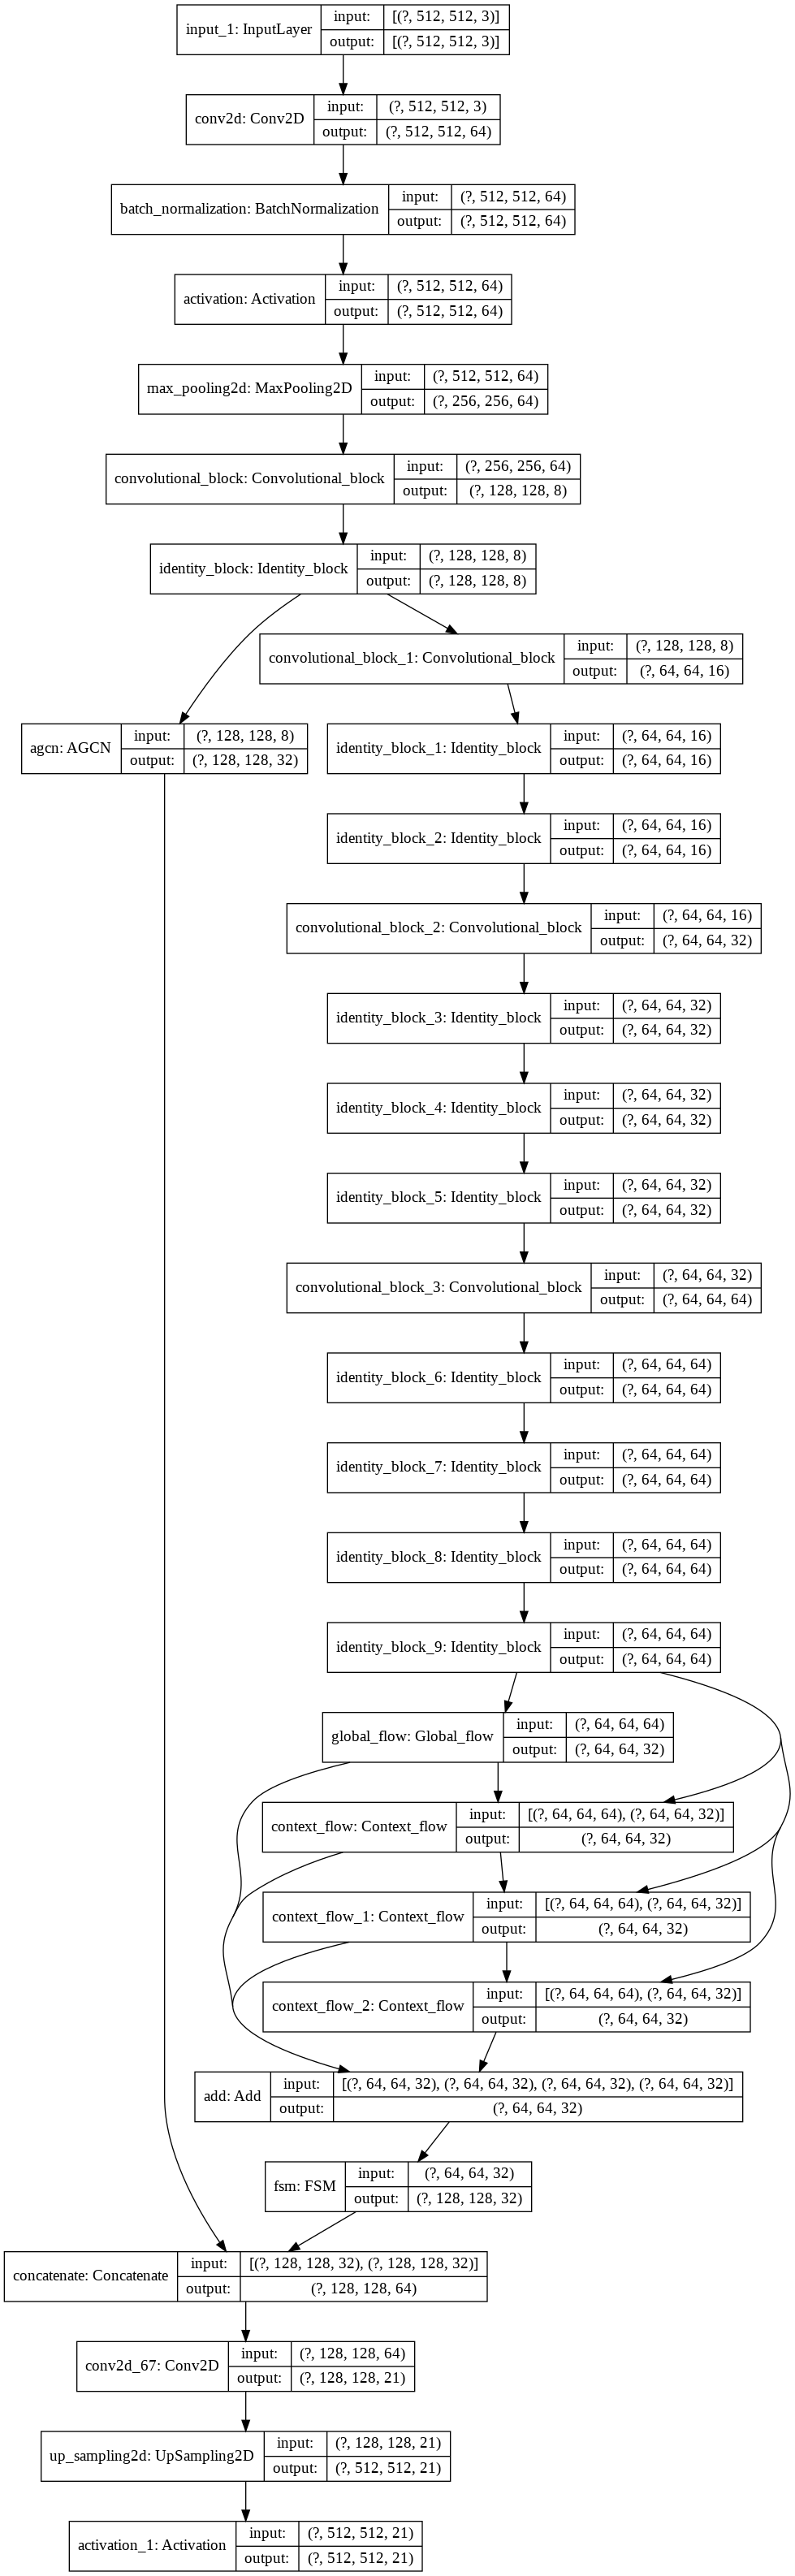

In [ ]:
tf.keras.utils.plot_model(
    model_canet, to_file='model_CANet.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

### <font color='green'>**CANet Model Traning**</font>

In [ ]:
!rm -r logs/

In [ ]:
from segmentation_models.metrics import IOUScore

#optim = tensorflow.keras.optimizers.Adam(0.001)

dice_cce_loss = sm.losses.DiceLoss() + sm.losses.CategoricalCELoss()
iou_metric = IOUScore(threshold=0.5, per_image=True)

model_canet = get_CANet_model()
model_canet.compile(optimizer='adam', loss=dice_cce_loss, metrics=[iou_metric])

# define callbacks for learning rate scheduling and best checkpoints saving
import datetime
log_dir="logs/1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True),
    keras.callbacks.ModelCheckpoint('best_canet_model.h5', save_weights_only=True, save_best_only=True, \
                                       verbose=1, mode='max', monitor='val_iou_score'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.00001, factor=0.5, patience=2, verbose=1, mode='max')
]

In [ ]:
# Nan loss issue - (Use softmax at the end!)\
# https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network

# Model saving issue - \
# https://stackoverflow.com/a/58799021/7697658
# https://stackoverflow.com/a/58119220/7697658
# https://stackoverflow.com/a/53099120/7697658
# https://github.com/harshtikuu/Abnormal_Event_Detection/issues/23
# https://github.com/keras-team/keras/issues/4871

model_canet_hist = model_canet.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=test_dataloader, validation_steps=len(test_dataloader), callbacks=callbacks)

Epoch 1/10
450/450 [==============================] - ETA: 0s - loss: 1.9180 - iou_score: 0.4488
Epoch 00001: val_iou_score improved from -inf to 0.46857, saving model to best_canet_model.h5
450/450 [==============================] - 673s 1s/step - loss: 1.9180 - iou_score: 0.4488 - val_loss: 1.3030 - val_iou_score: 0.4686 - lr: 0.0010
Epoch 2/10
450/450 [==============================] - ETA: 0s - loss: 1.1065 - iou_score: 0.4746
Epoch 00002: val_iou_score did not improve from 0.46857
450/450 [==============================] - 675s 1s/step - loss: 1.1065 - iou_score: 0.4746 - val_loss: 1.0648 - val_iou_score: 0.4560 - lr: 0.0010
Epoch 3/10
450/450 [==============================] - ETA: 0s - loss: 0.9495 - iou_score: 0.4838
Epoch 00003: val_iou_score did not improve from 0.46857

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
450/450 [==============================] - 671s 1s/step - loss: 0.9495 - iou_score: 0.4838 - val_loss: 0.9611 - val_iou_score: 0

In [ ]:
!zip -r logs.zip logs

In [ ]:
# # LOADING THE SAVED MODEL
# # https://stackoverflow.com/a/58119220/7697658
# #-------------------------
# model_best_canet = tf.keras.models.load_model('best_canet_model.hdf5', custom_objects={'cce_dice_loss':sm.losses.cce_dice_loss,\
#                                                                                        'iou_score':iou_score,\
#                                                                                        'Convolutional_block':Convolutional_block,\
#                                                                                        'Identity_block':Identity_block,\
#                                                                                        'Global_flow':Global_flow,\
#                                                                                        'Context_flow':Context_flow,\
#                                                                                        'FSM':FSM,\
#                                                                                        'AGCN':AGCN})
# model_best_canet.summary()

In [ ]:
best_canet_model = model_canet
best_canet_model.load_weights("best_canet_model.h5")

In [ ]:
iou_score_test = best_canet_model.evaluate_generator(test_dataloader, steps=len(test_dataloader))[1]
print("Best IOU score:", iou_score_test)

Best IOU score: 0.5137940049171448


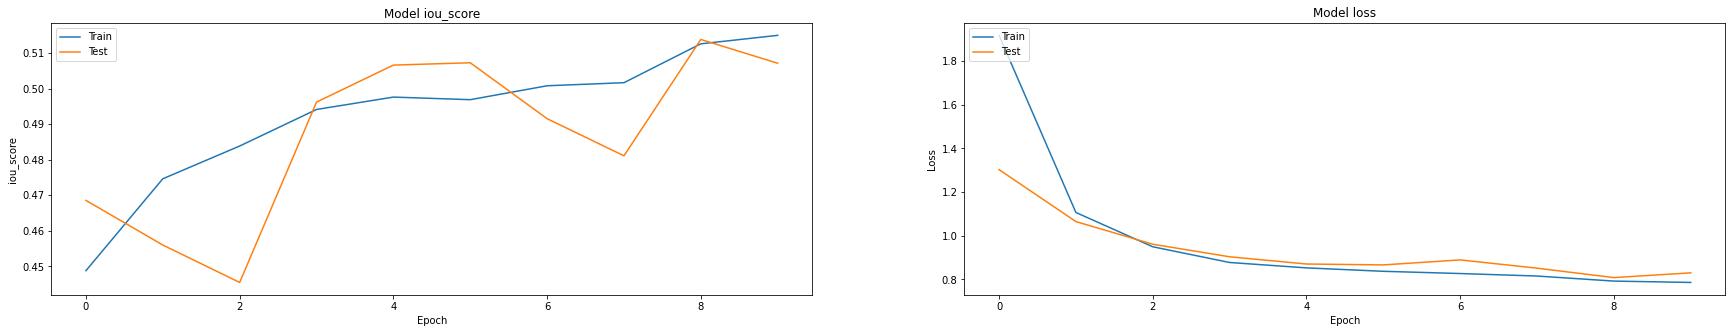

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model_canet_hist.history['iou_score'])
plt.plot(model_canet_hist.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model_canet_hist.history['loss'])
plt.plot(model_canet_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def infer_predicted_image(predicted, label_clr):
    #print("Predicted shape=>",predicted.shape)
    classes = list(set(label_clr.values()))
    for i in range(len(classes)):
        predicted[0,:,:,i] = np.where((predicted[0,:,:,i] > 0.5), classes[i], 0)

    predicted = np.sum(predicted, axis=-1)
    return predicted

def predict_image(model, X_df, num_of_images):
    for orig_im, _, mask_im in X_df.values:
        #original image
        image = cv2.imread(orig_im)
        #print("Original image shape =>",image.shape)
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print("Original image Resized shape =>",image.shape)

        #target mask image
        image_mask = cv2.imread(mask_im)
        #print("Mask image shape =>",image_mask.shape)
        image_mask = cv2.resize(image_mask, (512,512), interpolation=cv2.INTER_NEAREST)
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)
        #print("Mask image Resized shape =>",image_mask.shape)

        #predicted segmentation map
        predicted  = model.predict(image[np.newaxis,:,:,:])
        #print("Predicted shape =>",predicted.shape)
        plt.figure(figsize=(10,6))
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(image_mask[:,:,0])
        plt.subplot(133)
        predicted_image = infer_predicted_image(predicted, label_clr)
        #print("Predicted image shape =>",predicted_image.shape)
        #print("Predicted image shape =>",predicted_image.shape)
        plt.imshow(predicted_image[0,:,:])
        plt.show()
        num_of_images-=1
        if num_of_images==0:
            break

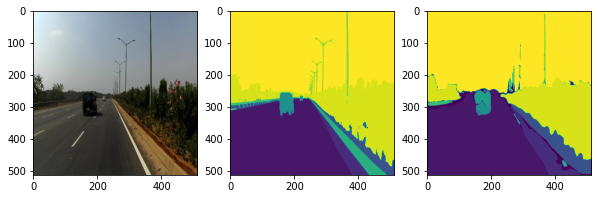

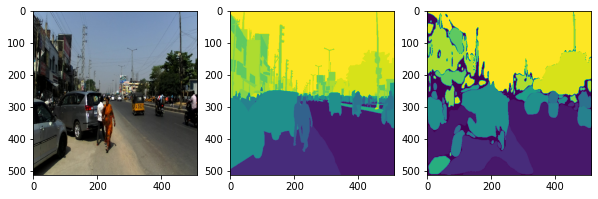

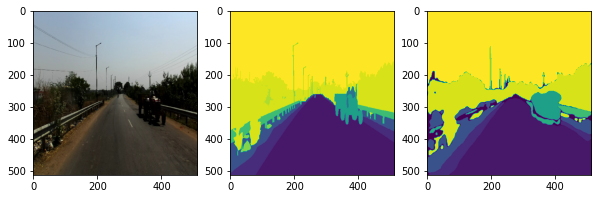

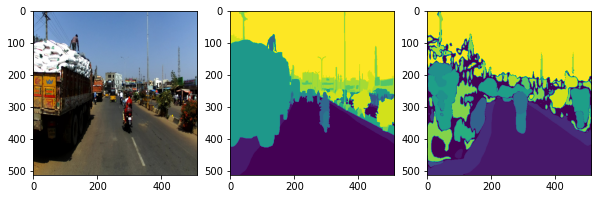

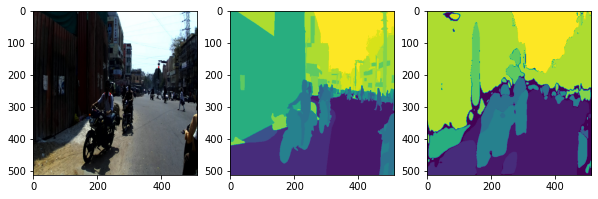

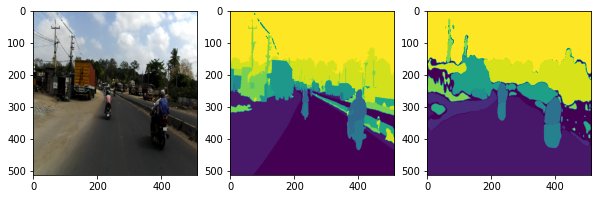

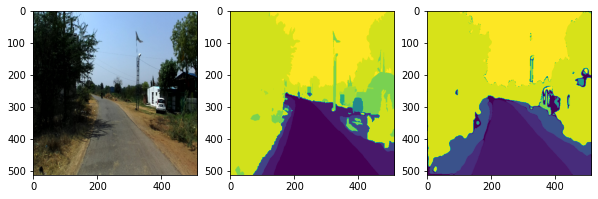

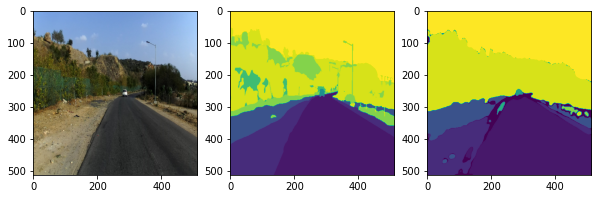

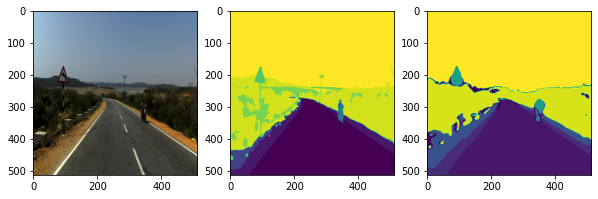

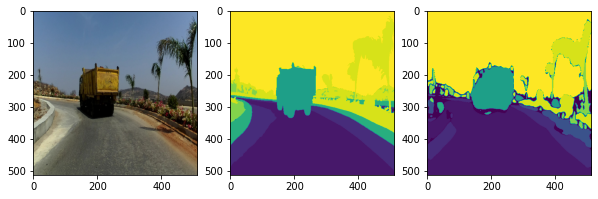

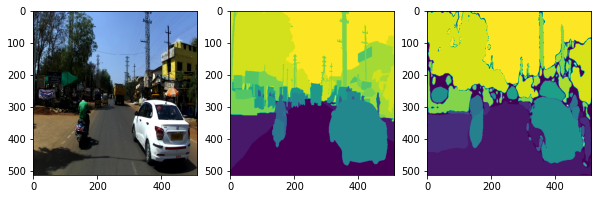

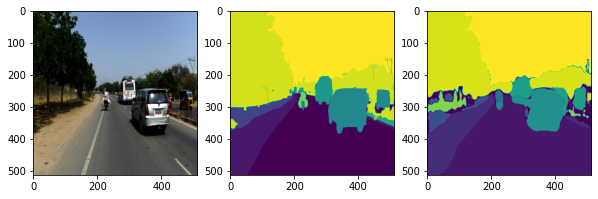

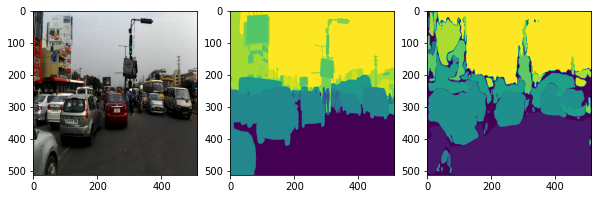

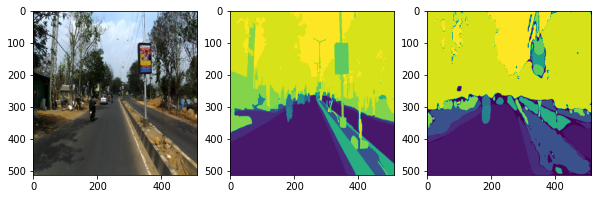

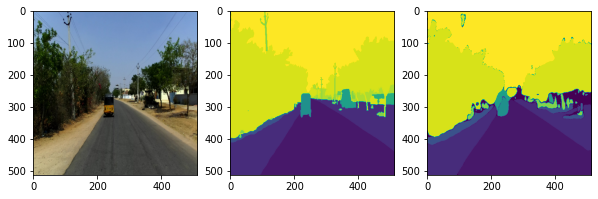

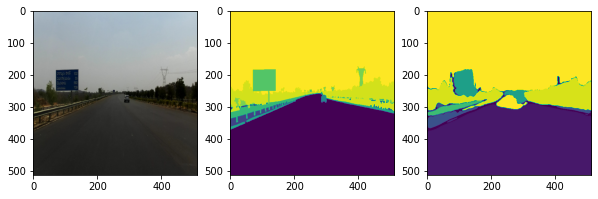

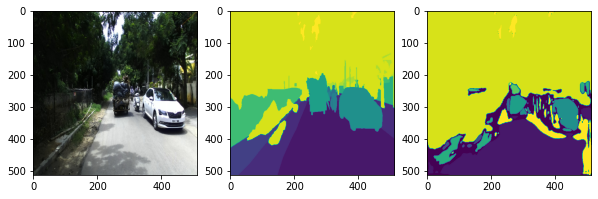

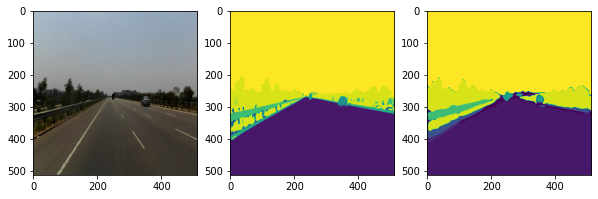

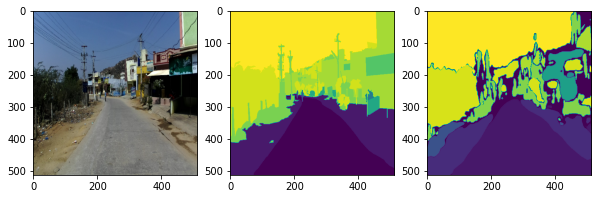

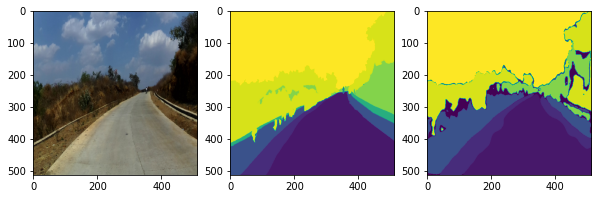

In [ ]:
predict_image(best_canet_model, X_test_df, num_of_images=20)

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Use the segmentation model's losses and the metrics